# Diffusion 

# Diffusion Basics

Diffusion models are a new and recent class of generative models that rely on a forward diffusion process and a backward denoising process. The forward diffusion process adds a little bit of noise at each step, thus making the input image progressively noisier. On the other hand, the aim of the backward process is to denoise at each step, and is supposed to reverse the effect of the forward process. In this setup, only the backward process is parameterized by a learnable model while the forward process converges to something known, like $\mathcal{N}(0, I)$. If the learning is done correctly and the backward process works well enough, it would ideally be able to progressively remove noise from complete noise and lead to a sample from the data distribution.

Now, lets try to formalize this. Suppose our data samples come from the distribution $q(x_0)$. The forward distribution can be parameterized as

\begin{align*}
q(x_t | x_{t-1}) = \mathcal{N}(\sqrt{1-\beta_t} x_{t-1}, \beta_t I)
\end{align*}

where if we consider a finite number of timesteps T, then

\begin{align*}
q(x_{1:T} | x_0) = \prod_{t=1}^T q(x_t | x_{t-1})
\end{align*}

where $\beta_t$ are the hyperparameters that govern how quickly structure is destroyed in the forward process. One can see this as progressively adding more noise to the input data. One benefit of considering a gaussian distribution above is that it leads to a very nice property that the distribution $q(x_t | x_0)$ becomes known and tractable, so one is able to directly generate a sample from any point in the forward trajectory. In particular, with a bit of algebra, one can obtain

\begin{align*}
q(x_t | x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)
\end{align*}

where $\bar{\alpha}_t = \prod_{i=1}^t \alpha_t$ and $\alpha_t = 1 - \beta_t$. And ideally we want to set $\beta_t$'s such that $q(x_T | x_0) \approx \mathcal{N}(0, I)$.

So far, we have obtained the forward structure-destroying diffusion process as well as how to sample directly from any point in the forward process conditioned on the initial conditions. Now, we want to learn a reverse process that takes us back from a noisy sample to something that has less noise. We do this by parameterizing this distribution with a Neural Network like

\begin{align*}
  p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} | x_t)
\end{align*}

where we consider $p(x_T)$ as just $\mathcal{N}(0, I)$ since at the end of the forward diffusion we are approximating that. Further, we also assume that each conditional above is parameterized as a gaussian distribution, that is

\begin{align*}
  p_\theta(x_{t-1} | x_t) = \mathcal{N}(\mu_\theta(x_t, t), \tilde{\beta}_t)
\end{align*}

where $\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$ which is because after doing some algebra, we can find that

\begin{align*}
  q(x_{t-1} | x_t, x_0) = \mathcal{N}(\tilde{\mu}_t, \tilde{\beta}_t)
\end{align*}

where $\tilde{\mu}_t = \frac{\sqrt{\alpha_t} ( 1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t}x_0$.

This particular parameterization of $q(x_{t-1} | x_t, x_0)$ follows through by considering the Bayes rule combined with some algebra. Since the backward learned process is aimed to approximate the true backward process $q(x_{t-1} | x_t, x_0)$, it boils down to matching the means $\tilde{\mu}_t$ with $\mu_\theta(x_t)$ as the variances are kept the same by design. A little more algebraic manipulation and reparameterization tricks lead us to

\begin{align*}
  \tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_t\right)
\end{align*}

To match this, we need $\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_t\right)
$

Given this formulation for $\mu_\theta$, we can use reparameterization to get $x_{t-1}$ from $x_t$ as

\begin{align*}
  x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_t\right) + \tilde{\beta}_t \epsilon
\end{align*}

Thus, instead of parameterizing $\mu_\theta$ using a Neural Network, one can parameterize $\epsilon_t$ using the network so that we can do the backward diffusion as

\begin{align*}
  x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t)\right) + \tilde{\beta}_t \epsilon
\end{align*}

In short, thus, we get a forward diffusion process parameterized as $q(x_t | x_{t-1} = \mathcal{N}(\sqrt{1 - \beta_t} x_{t-1}, \beta_t I)$ where one can sample $q(x_t | x_0)$ in one-shot in closed form without having to go through $t = 1, ..., t-1$. On the other hand, the backward process parameterizes the noise at time-step $t$, that is $\epsilon_\theta(x_t, t)$ which can be used to run the backward process as $p(x_{t-1} | x_t) = \mathcal{N}(\frac{1}{\sqrt{\alpha}_t} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t} }\epsilon_\theta(x_t, t)\right), \tilde{\beta}_t I)$.

And learning of this model leads to a simple objective function, which can be defined as
\begin{align*}
\mathbb{E}_{t\sim \mathcal{U}(1,T), x_0, \epsilon_t} \left[|| \epsilon_t - \epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t, t) ||^2\right]
\end{align*}

For our settings, instead of the $L_2$ loss, we will use the huber loss, which is $L_1$ loss but near the origin, acts as an $L_2$ loss. For details, refer [here](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). For more details about diffusion models, please refer to the [DDPM paper](https://arxiv.org/abs/2006.11239) and the related [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/).

In [ ]:
# !pip install -q -U einops datasets matplotlib tqdm

import random
import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset
from inspect import isfunction
from functools import partial
import math
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms

from pathlib import Path
from torch.utils.data import DataLoader

def fix_experiment_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

fix_experiment_seed()

results_folder = Path("./results_diffusion")
results_folder.mkdir(exist_ok = True)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Set up the hyperparameters
- Batch Size
- Latent Dimensionality
- Learning Rate
- Diffusion timesteps: $T$
- Starting variance: $\beta_1$
- Ending variance: $\beta_T$

In [2]:
# Training Hyperparameters
batch_size = 256  # Batch Size
z_dim = 32        # Latent Dimensionality
lr = 1e-4         # Learning Rate

# Hyperparameters taken from Ho et. al for noise scheduling
T = 1000            # Diffusion Timesteps
beta_start = 0.0001 # Starting variance
beta_end = 0.02     # Ending variance

In [3]:
# Define Dataset Statistics
image_size = 32
input_channels = 1

# Resize and Normalize the Data
transform = Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# Helper Functions
def show_image(image, nrow=8):
  # Input: image
  # Displays the image using matplotlib
  grid_img = make_grid(image.detach().cpu(), nrow=nrow, padding=0)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')

def transforms_examples(examples):
  if "image" in examples:
     examples["pixel_values"] = [transform(image) for image in examples["image"]]
     del examples["image"]
  else:
     examples["pixel_values"] = [transform(image) for image in examples["img"]]
     del examples["img"]

  return examples


def get_dataloaders():
    dataset = load_dataset("mnist", cache_dir='./data')
    transformed_dataset = dataset.with_transform(transforms_examples)

    train_dataloader = DataLoader(
        transformed_dataset["train"], batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_dataloader = DataLoader(
        transformed_dataset["test"], batch_size=batch_size, shuffle=False, drop_last=False
    )

    return train_dataloader, test_dataloader


## Visualize the Data

Let's visualize what our data actually looks like! We are using the [CIFAR-10](https://huggingface.co/datasets/cifar10) dataset. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes. It has a training set of 50,000 examples and a test set of 10,000 examples. The dataset is divided into five training batches and one test batch, each with 10,000 images. 

torch.Size([256, 1, 32, 32])


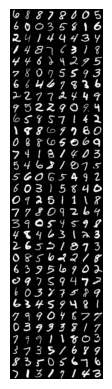

In [4]:
# Visualize the Dataset
def visualize():
  train_dataloader, _ = get_dataloaders()
  batch = next(iter(train_dataloader))
  print(batch['pixel_values'].shape)

  save_image((batch['pixel_values'] + 1.) * 0.5, './results_diffusion/orig.png')
  show_image((batch['pixel_values'] + 1.) * 0.5)

if __name__ == '__main__':
  visualize()

## Helper Functions / Building Blocks

some helper functions and building blocks that will allow creation of the U-Net network that parameterizes the backward noise prediction network in diffusion models.

In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=128, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 32)
        self.down1 = Down(32, 64)
        #self.sa1 = SelfAttention(64)
        self.down2 = Down(64, 128)
        #self.sa2 = SelfAttention(128)
        self.down3 = Down(128, 128)
        #self.sa3 = SelfAttention(128)


        if remove_deep_conv:
            self.bot1 = DoubleConv(128, 128)
            self.bot3 = DoubleConv(128, 128)
        else:
            self.bot1 = DoubleConv(128, 256)
            self.bot2 = DoubleConv(256, 256)
            self.bot3 = DoubleConv(256, 128)

        self.up1 = Up(256, 64)
        #self.sa4 = SelfAttention(64)
        self.up2 = Up(128, 32)
        #self.sa5 = SelfAttention(32)
        self.up3 = Up(64, 32)
        #self.sa6 = SelfAttention(32)
        self.outc = nn.Conv2d(32, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=t.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        #x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        #x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        #x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        #x = self.sa4(x)
        x = self.up2(x, x2, t)
        #x = self.sa5(x)
        x = self.up3(x, x1, t)
        #x = self.sa6(x)
        output = self.outc(x)
        return output

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)


def load_weights(eps_model, PATH):

    try:
        checkpoint = torch.load(PATH, weights_only=True)
        eps_model.load_state_dict(checkpoint['model_state_dict'])
        eps_model.eval()
        print('UNet model loaded (in eval mode)!')
        return eps_model

    except:
        print('No weights to load')
        return eps_model


We define a helper function *extract* which takes as input a tensor *a* and an index tesor *t* and returns another tensor where the $i^{th}$ element of this new tensor corresponds to $a[t[i]]$.

In [6]:
def extract(a, t, x_shape):
  # Takes a data tensor a and an index tensor t, and returns a new tensor
  # whose i^th element is just a[t[i]]. Note that this will be useful when
  # we would want to choose the alphas or betas corresponding to different
  # indices t's in a batched manner without for loops.
  # Inputs:
  #   a: Tensor, generally of shape (batch_size,)
  #   t: Tensor, generally of shape (batch_size,)
  #   x_shape: Shape of the data, generally (batch_size, 3, 32, 32)
  # Returns:
  #   out: Tensor of shape (batch_size, 1, 1, 1) generally, the number of 1s are
  #         determined by the number of dimensions in x_shape.
  #         out[i] contains a[t[i]]

  batch_size = t.shape[0]
  out = a.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

Now, we define the different coefficients that are required in the diffusion process. In particular, we need to define the following tensors, all of which are of size $(T,)$. Also note that we are using indexing starting from 1 here, in the code all the variables with $t=1$ are set at position 0.

- betas: Contains $\beta_t$ from the linear scheduling between $\beta_1$ and $\beta_T$, sampled over $T$ intervals
- alphas: Contains $\alpha_t = 1-\beta_t$
- sqrt_recip_alphas: Contains $\frac{1.}{\sqrt{{\alpha}_t}}$
- alphas_cumprod: Contains $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$
- sqrt_alphas_cumprod: Contains $\sqrt{\bar{\alpha}_t}$
- sqrt_one_minus_alphas_cumprod: Contains $\sqrt{1 - \bar{\alpha}_t}$
- alphas_cumprod_prev: Right shift $\bar{\alpha}_t$; thus contains $\prod_{i=1}^{t-1} \alpha_i$ with the first element as 1.
- posterior_variance: Contains $\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$

In [7]:
def alphas_betas_sequences_helper(beta_start, beta_end, T):
    def linear_beta_schedule(beta_start, beta_end, timesteps):
        return torch.linspace(beta_start, beta_end, timesteps)

    betas = linear_beta_schedule(beta_start, beta_end, T)                           # Define the linear beta schedule
    alphas = 1. - betas                                                             # Compute the alphas as 1 - betas
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)                                    # Returns 1/square_root(\alpha_t)
    alphas_cumprod = torch.cumprod(alphas, axis=0)                                  # Compute product of alphas up to index t, \bar{\alpha}
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)                                # Returns sqaure_root(\bar{\alpha}_t)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)                 # Returns square_root(1 - \bar{\alpha}_t)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)             # Right shifts \bar{\alpha}_t; with first element as 1.
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # Contains the posterior variances $\tilde{\beta}_t$

    return betas, alphas, sqrt_recip_alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, alphas_cumprod_prev, posterior_variance

betas, alpha, sqrt_recip_alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, alphas_cumprod_prev, posterior_variance = alphas_betas_sequences_helper(beta_start, beta_end, T)

# Forward Diffusion Process

To define the forward diffusion, we need to model the distribution $q(x_t | x_0)$ in a manner that does not go through $t = 1, ..., t-1$. In particular, as defined at the start, we can obtain the distribution as

\begin{align*}
  q(x_t | x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)
\end{align*}

have already computed the required coefficients above,task is to now complete the function q_sample which takes $(x_0, t)$ as input and returns a sample from $q(x_t | x_0)$ in a batched manner, that is, in parallel for a batch of $x_0$'s and a batch of different timesteps $t$, can use the extract function provided to get the coefficients at the right timesteps.

In [8]:
from diffusion_solution import q_sample

Let's test the forward diffusion process on a particular image sample. We will see that the sample progressively loses all structure and ends up close to completely random noise.

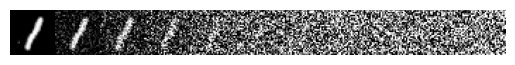

In [9]:
def visualize_diffusion():
  train_dataloader, _ = get_dataloaders()
  batch = next(iter(train_dataloader))
  sample = batch['pixel_values'][3].unsqueeze(0)
  coefficients = (
      sqrt_alphas_cumprod,
      sqrt_one_minus_alphas_cumprod,
  )
  noisy_images = [sample] + [q_sample(sample, torch.tensor([100 * t + 99]), coefficients) for t in range(10)]
  noisy_images = (torch.cat(noisy_images, dim=0) + 1.) * 0.5
  show_image(noisy_images.clamp(0., 1.), nrow=11)

if __name__ == '__main__':
  visualize_diffusion()

# Backward Learned Diffusion Process

Now suppose you have access to the model $\epsilon_\theta$ in the above description of diffusion models. We know that given a noisy sample $x_t$, one can obtain a slightly denoised version of this sample through the distribution $p_\theta(x_{t-1} | x_t)$, which in our setup is now defined as

\begin{align*}
p_\theta(x_{t-1} | x_t) = \mathcal{N}(\frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right), \tilde{\beta}_t I)
\end{align*}

Below, the task is to complete the function p_sample that takes as input the denoising model $\epsilon_\theta$, a batched noisy image $x$, a batched time-step $t$ and a scalar $t\_index$, and it has to return a sample from $p(x_{t-1} | x_t)$. In the case that $t=1$ (or in code, $t=0$), return the mode instead of a sample. For doing this if-condition, can use $t\_index$ which is just a scalar instead of its batched variant $t$.

Note that all the coefficients $\bar{\alpha}_t$, etc. are already computed above for all $t$, so use the extract function provided to obtain them at different corresponding timesteps.

In [10]:
from diffusion_solution import p_sample, p_sample_loop

def sample(model, image_size, batch_size=16, channels=3):
    # Returns a sample by running the sampling loop
    with torch.no_grad():
        return p_sample_loop(
            model,
            shape=(batch_size, channels, image_size, image_size),
            timesteps=T,
            T=T,
            coefficients=(
                betas,
                sqrt_one_minus_alphas_cumprod,
                sqrt_recip_alphas,
                posterior_variance,
            ),
            noise=None
        )



# Define the Loss

Now that we have both the forward and the backward diffusion process ready, we need a training criterion. In the introduction, we already saw that the optimization objective for training is to minimize:

\begin{align*}
\mathbb{E}_{t\sim \mathcal{U}(1,T), x_0, \epsilon_t} \left[|| \epsilon_t - \epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t, t) ||^2\right]
\end{align*}

This boils down to

- Generating some gaussian noise from $\mathcal{N}(0, I)$.
- Getting the noisy images at time $t$ in a batched, one-shot fashion.
- Getting the estimate of noise from the noisy images.
- Computing the loss between the estimate of noise and the actual noise.

In practice here, we will use the **huber** loss instead of the squared loss; so please implement that. Feel free to use PyTorch's criterion to get the huber loss formulation.

In [11]:
from diffusion_solution import p_losses

### Random sampling of time-step

Finally, randomly sample time-steps from a uniform distribution over timesteps, and return a tensor of size (batch\_size,)

In [12]:
from diffusion_solution import t_sample

Having defined all the ingredients for **training** and **sampling** from this model, we now define the model itself and the optimizer used for training.

In [13]:
if __name__ == '__main__':
  model = UNet(c_in=1, c_out=1)
  model.to(device)
  model.device=device

  optimizer = Adam(model.parameters(), lr=lr)

Finally, let's start training!
Visualization of the samples generated, the original dataset and the reconstructions are saved locally in the notebook! Task is to just provide sampling of time-steps t, which should be a tensor of size (batch\_size,) sampled uniformly from $[0, T-1]$.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-19.020126..22.103441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.5057755..5.5144386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5635955..1.3695424].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.674824..3.6763005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6056453..1.3993424].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4944762..1.3558393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6288793

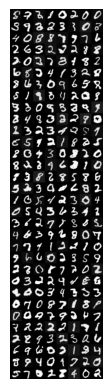

In [14]:
epochs = 15

if __name__ == '__main__':
  train_dataloader, test_dataloader = get_dataloaders()
  sample(model, image_size=image_size, batch_size=256, channels=input_channels)
  for epoch in range(epochs):
    with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch: {epoch}")

        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        x = batch["pixel_values"].to(device)

        t = t_sample(T, batch_size, x.device) # Randomly sample timesteps uniformly from [0, T-1]

        loss = p_losses(model, x, t, (sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod))

        loss.backward()
        optimizer.step()

        tepoch.set_postfix(loss=loss.item())

    # Sample and Save Generated Images
    save_image((x + 1.) * 0.5, './results_diffusion/orig.png')
    samples = sample(model, image_size=image_size, batch_size=256, channels=input_channels)
    samples = (torch.Tensor(samples[-1]) + 1.0) * 0.5
    save_image(samples, f"./results_diffusion/ddpm_samples_{epoch}.png")

    show_image(samples)

## Classifier Free Guidance

### Overview
**Classifier-Free Guidance (CFG)** is a technique introduced by *Ho & Salimans (2021)* to improve the quality and controllability of diffusion model sampling **without** relying on a separate classifier network.  
Instead of using an external classifier to steer the generation toward a target class, CFG trains **a single model** that can operate in both **conditional** and **unconditional** modes.



### Key Idea
During training, the model is conditioned on a label (e.g., an MNIST digit) only part of the time.  
With probability $p_{\text{uncond}}$, the label is **dropped** (replaced by `None` or a special token).

This encourages the model $\epsilon_\theta(x_t, t, y)$ to learn two behaviors:
- **Conditional mode:** predict noise given both the noisy image $x_t$ and label $y$  
- **Unconditional mode:** predict noise given only $x_t$

At inference time, combine unconditional and conditional predictions with a **guidance scale** $s$:
\begin{align*}
\hat{\epsilon}_\theta(x_t, t, y)
&= \epsilon_\theta(x_t, t, \text{None})
\;+\; s\Big(\epsilon_\theta(x_t, t, y) - \epsilon_\theta(x_t, t, \text{None})\Big)
\end{align*}

Interpretation of $s$:
- $s=0$: purely unconditional generation  
- $s=1$: standard conditional sampling  
- $s>1$: stronger conditioning (typically more class-consistent, possibly less diverse)



### Training Steps
1. Sample a clean image $x_0$ and its label $y$.
2. Add Gaussian noise to get a noisy sample at time $t$:
\begin{align*}
x_t \;=\; \sqrt{\bar{\alpha}_t}\,x_0 \;+\; \sqrt{1-\bar{\alpha}_t}\,\epsilon,
\qquad \epsilon \sim \mathcal{N}(0, I)
\end{align*}
3. With probability $p_{\text{uncond}}$, drop the label and train the model to predict $\epsilon$ from $(x_t, t, y^*)$, where $y^*$ is either $y$ or `None`.
4. Optimize a noise-prediction loss (e.g., MSE or Huber) between the predicted and true noise.


### Sampling Steps
For each reverse diffusion step $t$:
\begin{align*}
\epsilon_{\text{uncond}} &= \epsilon_\theta(x_t, t, \text{None}) \\
\epsilon_{\text{cond}}   &= \epsilon_\theta(x_t, t, y) \\
\hat{\epsilon}_\theta     &= \epsilon_{\text{uncond}} + s\big(\epsilon_{\text{cond}} - \epsilon_{\text{uncond}}\big)
\end{align*}
Use $\hat{\epsilon}_\theta$ inside the reverse diffusion update to progressively denoise $x_t \rightarrow x_0$.


### Helper Functions / UNet for Conditional Generation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=64):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, labels=None):
        x = self.maxpool_conv(x)
        if labels is not None:
            emb = self.emb_layer(labels)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
            x += emb
        return x


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=64):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, labels=None):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        if labels is not None:
            emb = self.emb_layer(labels)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
            x += emb
        return x


class UNet(nn.Module):
    """
    Time-conditioned UNet (unconditional wrt labels).
    Keeps original channels and block structure.
    """
    def __init__(self, c_in=3, c_out=3, c_emb_dim=64, remove_deep_conv=False):
        super().__init__()
        self.c_emb_dim = c_emb_dim            # embedding dim used in Down/Up emb_layers
        self.remove_deep_conv = remove_deep_conv

        self.inc = DoubleConv(c_in, 16)
        self.down1 = Down(16, 32, emb_dim=c_emb_dim)
        self.down2 = Down(32, 64, emb_dim=c_emb_dim)
        self.down3 = Down(64, 64, emb_dim=c_emb_dim)

        if remove_deep_conv:
            self.bot1 = DoubleConv(64, 64)
            self.bot3 = DoubleConv(64, 64)
        else:
            self.bot1 = DoubleConv(64, 128)
            self.bot2 = DoubleConv(128, 128)
            self.bot3 = DoubleConv(128, 64)

        self.up1 = Up(128, 32, emb_dim=c_emb_dim)
        self.up2 = Up(64, 16, emb_dim=c_emb_dim)
        self.up3 = Up(32, 16, emb_dim=c_emb_dim)
        self.outc = nn.Conv2d(16, c_out, kernel_size=1)

    # --- sinusoidal time embedding to size c_emb_dim (minimal change) ---
    def pos_encoding(self, t, channels):
        """
        t: (B, 1) float
        channels: output size (= self.c_emb_dim)
        """
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=t.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        if pos_enc.shape[-1] < channels:  # pad if odd
            pad = torch.zeros(pos_enc.shape[0], 1, device=t.device, dtype=pos_enc.dtype)
            pos_enc = torch.cat([pos_enc, pad], dim=-1)
        return pos_enc

    def unet_forwad(self, x, labels):
        x1 = self.inc(x)
        x2 = self.down1(x1, labels)
        x3 = self.down2(x2, labels)
        x4 = self.down3(x3, labels)

        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, labels)
        x = self.up2(x, x2, labels)
        x = self.up3(x, x1, labels)
        output = self.outc(x)
        return output

    def forward(self, x, t):
        """
        x: (B,C,H,W)
        t: (B,) or (B,1) integer/float timesteps
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        t = t.float()
        # Produce time embedding of size self.c_emb_dim
        t_emb = self.pos_encoding(t, self.c_emb_dim)  # (B, c_emb_dim)
        return self.unet_forwad(x, t_emb)


class UNet_conditional(UNet):
    """
    Conditional UNet: adds class-label conditioning on top of time conditioning.
    Keeps the same internal block APIs; just sums label embedding with time embedding.
    """
    def __init__(self, c_in=3, c_out=3, c_emb_dim=64, num_classes=None, **kwargs):
        super().__init__(c_in, c_out, c_emb_dim, **kwargs)
        self.num_classes = num_classes
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, c_emb_dim)

    def forward(self, x, t, y=None):
        """
        x: (B,C,H,W)
        t: (B,) or (B,1) timesteps
        y: (B,) class indices or None (for unconditional branch in CFG)
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        t = t.float()

        # time embedding (size = c_emb_dim)
        t_emb = self.pos_encoding(t, self.c_emb_dim)

        # label embedding (or zeros), same size so we can sum
        if (y is not None) and (self.num_classes is not None):
            y_emb = self.label_emb(y)
        else:
            y_emb = torch.zeros_like(t_emb)

        cond = t_emb + y_emb  # sum keeps it minimal and effective
        return self.unet_forwad(x, cond)


def load_weights(eps_model, PATH):
    try:
        checkpoint = torch.load(PATH, map_location="cpu")
        if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
            eps_model.load_state_dict(checkpoint["model_state_dict"])
        else:
            eps_model.load_state_dict(checkpoint)
        eps_model.eval()
        print('UNet model loaded (in eval mode)!')
        return eps_model
    except Exception as e:
        print(f'No weights to load ({e})')
        return eps_model


# Forward Diffusion Process

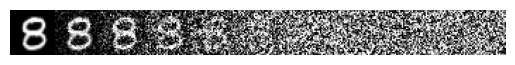

In [16]:
from CFGdiffusion_solution import q_sample

def visualize_diffusion():
  train_dataloader, _ = get_dataloaders()
  batch = next(iter(train_dataloader))
  sample = batch['pixel_values'][3].unsqueeze(0)
  coefficients = (
      sqrt_alphas_cumprod,
      sqrt_one_minus_alphas_cumprod,
  )
  noisy_images = [sample] + [q_sample(sample, torch.tensor([100 * t + 99]), coefficients) for t in range(10)]
  noisy_images = (torch.cat(noisy_images, dim=0) + 1.) * 0.5
  show_image(noisy_images.clamp(0., 1.), nrow=11)

if __name__ == '__main__':
  visualize_diffusion()

# Backward Learned Diffusion Process with Conditional Generation

In [17]:
from CFGdiffusion_solution import  p_sample, p_sample_loop

def sample_cfg(model, image_size, batch_size, channels, y, guidance_scale):
    with torch.no_grad():
        return p_sample_loop(
            model,
            shape=(batch_size, channels, image_size, image_size),
            timesteps=T,
            T=T,
            coefficients=(
                betas,
                sqrt_one_minus_alphas_cumprod,
                sqrt_recip_alphas,
                posterior_variance,
            ),
            y=y,
            guidance_scale=guidance_scale,
            noise=None
        )

## Defining Loss and Training Loop

In [18]:
model = UNet_conditional(c_in=1, c_out=1, num_classes=10)
model.to(device)
model.device=device

optimizer = Adam(model.parameters(), lr=lr)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.86899..182.51215].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-43.88237..88.36876].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-31.604317..51.51119].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-22.664341..25.715578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18.971884..31.039946].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.050802..11.122872].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6691108..1

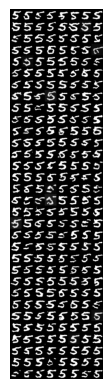

In [19]:
from CFGdiffusion_solution import  t_sample, p_losses

epochs = 15
batch_size = 256
guidance_scale = 3.5     # try 1.5–3.5 for MNIST
p_uncond = 0.1           # label dropout prob during training
num_classes = 10

if __name__ == "__main__":
    train_dataloader, test_dataloader = get_dataloaders()

    _ = sample_cfg(
        model, image_size=image_size, batch_size=16, channels=input_channels,
        y=torch.full((16,), 0, dtype=torch.long, device=device),  # digit '0'
        guidance_scale=guidance_scale
    )

    for epoch in range(epochs):
        model.train()
        with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch: {epoch}")

                optimizer.zero_grad()
                x = batch["pixel_values"].to(device)
                y = batch["label"].to(device).long()
                B = x.shape[0]

                t = t_sample(T, B, x.device)
                loss = p_losses(
                    denoise_model=model,
                    x_start=x,
                    t=t,
                    coefficients=(sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod),
                    y=y,
                    p_uncond=p_uncond,
                    noise=None,
                    loss_type="l2",
                )
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())



        model.eval()
        with torch.no_grad():
            n_samples = 256


            target_label = 5
            y_cond = torch.full((n_samples,), target_label, dtype=torch.long, device=device)

            imgs_all_steps = sample_cfg(
                model,
                image_size=image_size,
                batch_size=n_samples,
                channels=input_channels,
                y=y_cond,
                guidance_scale=guidance_scale
            )
            x_T0 = imgs_all_steps[-1]
            x_vis = (x_T0 + 1.0) * 0.5

            save_image((x[:256] + 1.) * 0.5, f'./results_diffusion/orig_e{epoch}.png', nrow=8)
            save_image(x_vis, f'./results_diffusion/cfg_label{target_label}_e{epoch}.png', nrow=8)
            show_image(x_vis, nrow=8)